# STOCK MARKET PREDICTION (NASDAQ COMPOSITES)

- I have taken the dataset as **NASDAQ Composites** as it includes almost all stocks listed on the Nasdaq stock exchange.
- I downloaded the stock price data **from 01 January 2001 to
 21 June 2024**. We have done the analysis and stock price prediction using three models which are LSTM , XGBoost and Random Forest and compared their results.
- For each model we divided the dataset into training , validation and testing set and got our final results based on the test dataset.

### INITIAL ANALYSIS

**Import Libraries**: We import necessary libraries such as Pandas, NumPy, Matplotlib, Torch, and yfinance for data manipulation, visualization, deep learning, and downloading stock data, respectively.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import yfinance as yf

**Download Stock Data**: We use the yfinance library to download historical stock data for the NASDAQ Composite Index (^IXIC) from Yahoo Finance. The data is downloaded for the time period from January 1, 2001, to June 21, 2024.


In [2]:
data = yf.download("^IXIC", start="2001-01-01", end="2024-06-21")
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,2474.159912,2474.159912,2273.070068,2291.860107,2291.860107,1918930000
2001-01-03,2254.560059,2618.030029,2251.709961,2616.689941,2616.689941,3188000000
2001-01-04,2593.959961,2644.800049,2549.830078,2566.830078,2566.830078,2610680000
2001-01-05,2573.110107,2574.620117,2395.389893,2407.649902,2407.649902,2104670000
2001-01-08,2388.719971,2397.060059,2299.649902,2395.919922,2395.919922,1850590000
...,...,...,...,...,...,...
2024-06-13,17715.269531,17741.800781,17566.320312,17667.560547,17667.560547,4916020000
2024-06-14,17621.179688,17693.429688,17590.800781,17688.880859,17688.880859,4973820000
2024-06-17,17697.300781,17935.990234,17636.359375,17857.019531,17857.019531,6061200000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5903 entries, 2001-01-02 to 2024-06-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5903 non-null   float64
 1   High       5903 non-null   float64
 2   Low        5903 non-null   float64
 3   Close      5903 non-null   float64
 4   Adj Close  5903 non-null   float64
 5   Volume     5903 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 322.8 KB


**Decomposition**: The `seasonal_decompose` function decomposes the original time series data into its trend, seasonal, and residual components. It assumes an additive model and a periodicity of 252 (assuming annual seasonality).

**Visualization**: The decomposed components (trend, seasonal, and residual) are plotted in separate subplots using Matplotlib. The original time series is plotted along with its components to visualize their individual contributions to the overall series.

   - The first subplot displays the original time series.
   - The second subplot shows the trend component.
   - The third subplot displays the seasonal component.
   - The fourth subplot visualizes the residual component.

By visualizing the decomposition components, we can gain insights into the underlying patterns and structures present in the time series data, which can aid in further analysis and forecasting.

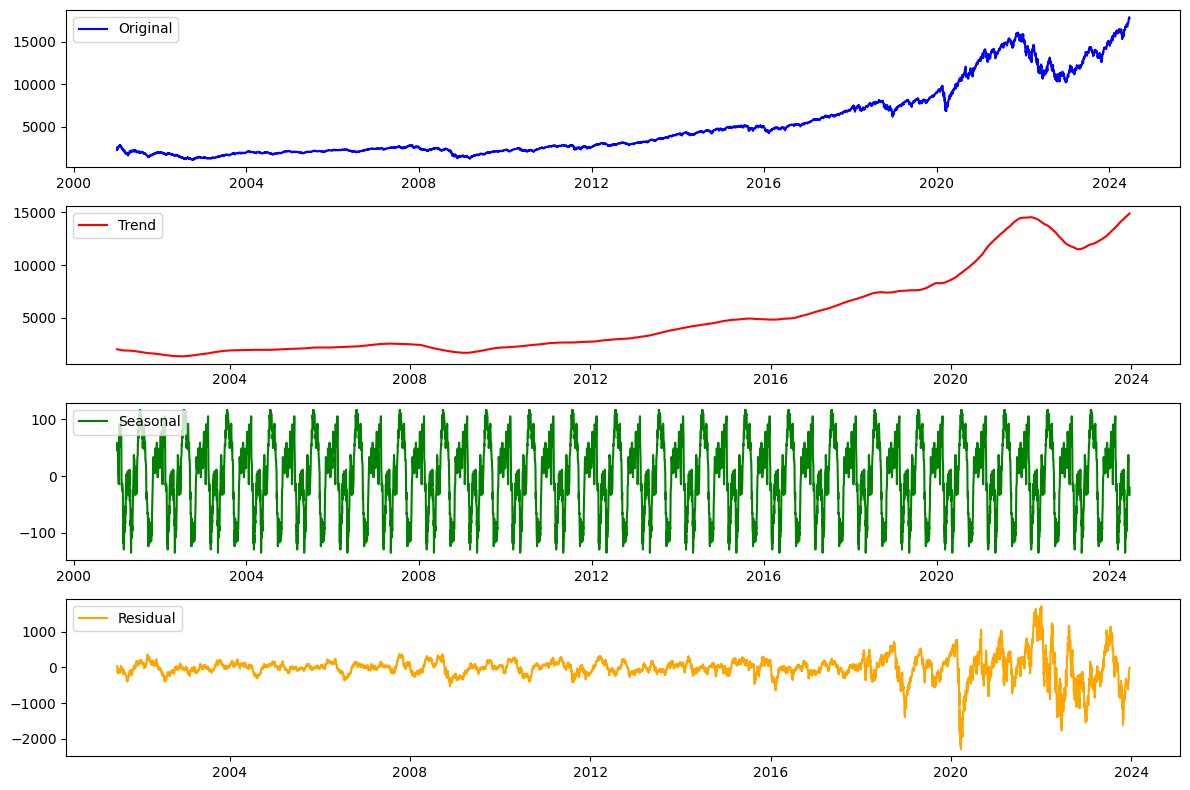

In [4]:
# Perform time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(data['Close'], model='additive', period=252)  # Assuming annual seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot decomposition components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(data['Close'], label='Original', color='blue')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color='red')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal', color='green')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual', color='orange')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Moving Averages Calculation**:
   - Two types of moving averages are calculated: Simple Moving Average (SMA) and Exponential Moving Average (EMA).
   - For each type, both 50-day and 200-day moving averages are computed.
   - The Simple Moving Averages are calculated using the `rolling` method with a specified window size (50 days and 200 days).
   - The Exponential Moving Averages are calculated using the `ewm` method with a specified span (50 days and 200 days).

This visualization allows us to compare the original price data with different types and lengths of moving averages, providing insights into trends and potential points of interest in the data.


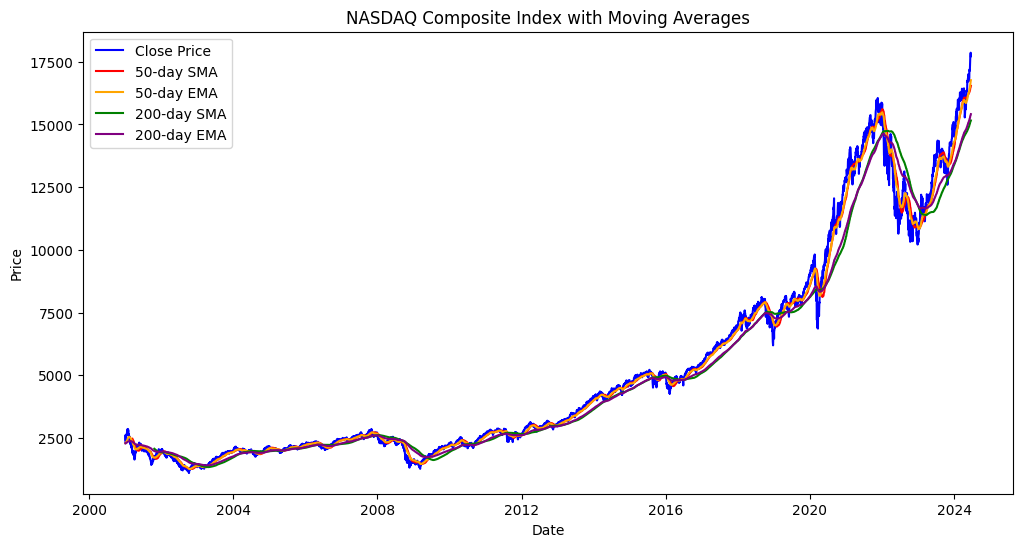

In [5]:
# Calculate 50-day and 200-day moving averages
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# Calculate 50-day and 200-day exponential moving averages
data['EMA50'] = data['Close'].ewm(span=50, adjust=False).mean()
data['EMA200'] = data['Close'].ewm(span=200, adjust=False).mean()

# Plot moving averages
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['SMA50'], label='50-day SMA', color='red')
plt.plot(data['EMA50'], label='50-day EMA', color='orange')
plt.plot(data['SMA200'], label='200-day SMA', color='green')
plt.plot(data['EMA200'], label='200-day EMA', color='purple')
plt.title('NASDAQ Composite Index with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### LSTM MODEL

General LSTM Model Structure.

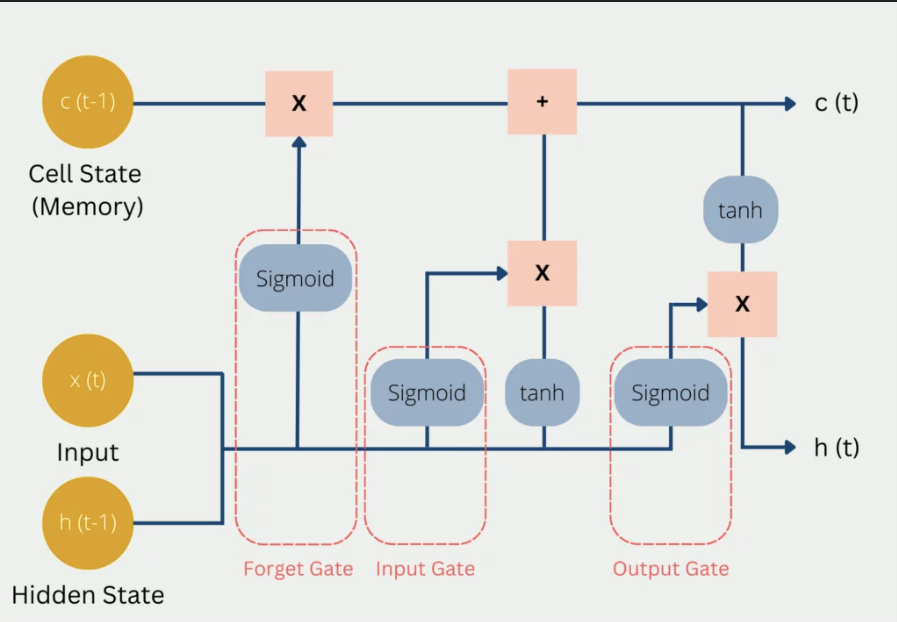

**Check Device Availability**: We check whether a GPU is available for computation using PyTorch. If a CUDA-enabled GPU is available, we set the device to 'cuda:0'; otherwise, we use the CPU for computation. This is checked as GPU availiability has an advantage of fast computation and memory efficiency.


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

**Plot Close Prices**: We plot the 'Close' prices of the downloaded stock data using Matplotlib. The plot provides a visual representation of how the stock prices have changed over time.


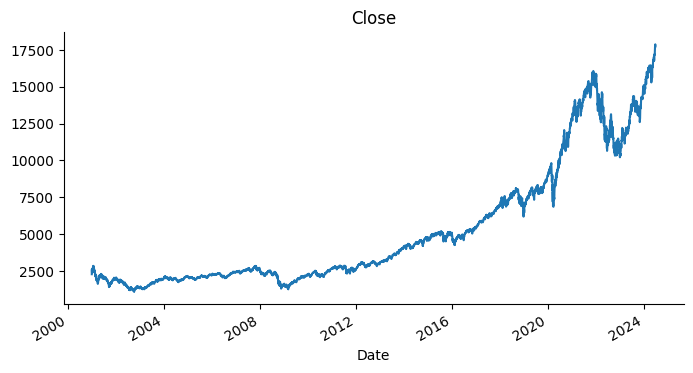

In [7]:
data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

We extract the Close column from the dataframe as we will be using only the close price for future stock price prediction.

In [8]:
data = data[['Close']]
data

,Close
Date,
2001-01-02,2291.860107
2001-01-03,2616.689941
2001-01-04,2566.830078
2001-01-05,2407.649902
2001-01-08,2395.919922
...,...
2024-06-13,17667.560547
2024-06-14,17688.880859
2024-06-17,17857.019531


**Prepare Dataframe for LSTM**: We define a function prepare_dataframe_for_lstm that prepares the stock data for LSTM modeling by creating shifted columns representing past observations of the 'Close' price. The n_steps parameter specifies the number of past observations to consider. In this case, n_steps is set to 7, indicating that we consider the previous 7 days' closing prices to predict the current day's closing price.

Explanation of prepare_dataframe_for_lstm Function:
The function takes two arguments: df (the dataframe containing the stock data) and n_steps (the number of past observations to consider).
We create a deep copy of the input dataframe using deepcopy from the copy module to avoid modifying the original dataframe.
We loop through each value of n_steps and create shifted columns for the 'Close' price, where each column represents the closing price i days ago. For example, Close(t-1) represents the closing price 1 day ago, Close(t-2) represents the closing price 2 days ago, and so on.
We drop rows with NaN values resulting from the shift operation.
Finally, we return the modified dataframe with shifted columns representing past observations of the 'Close' price.

Then we apply the prepare_dataframe_for_lstm function to the downloaded stock data (data) with a lookback period of 7 days. This creates a new dataframe (shifted_df) with shifted columns representing past observations of the 'Close' price, which can be used for LSTM modeling.

In [9]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2001-01-11,2640.570068,2524.179932,2441.300049,2395.919922,2407.649902,2566.830078,2616.689941,2291.860107
2001-01-12,2626.500000,2640.570068,2524.179932,2441.300049,2395.919922,2407.649902,2566.830078,2616.689941
2001-01-16,2618.550049,2626.500000,2640.570068,2524.179932,2441.300049,2395.919922,2407.649902,2566.830078
2001-01-17,2682.780029,2618.550049,2626.500000,2640.570068,2524.179932,2441.300049,2395.919922,2407.649902
2001-01-18,2768.489990,2682.780029,2618.550049,2626.500000,2640.570068,2524.179932,2441.300049,2395.919922
...,...,...,...,...,...,...,...,...
2024-06-13,17667.560547,17608.439453,17343.550781,17192.529297,17133.130859,17173.119141,17187.900391,16857.050781
2024-06-14,17688.880859,17667.560547,17608.439453,17343.550781,17192.529297,17133.130859,17173.119141,17187.900391
2024-06-17,17857.019531,17688.880859,17667.560547,17608.439453,17343.550781,17192.529297,17133.130859,17173.119141


We do the above preprocessing step because LSTM models are designed to capture temporal dependencies in sequential data. By feeding the model sequences of past observations, we enable it to learn patterns and relationships between past and present values of the target variable. In the case of stock price prediction, the past closing prices are relevant indicators for predicting future prices.


Now we convert our shifted dataframe into numpy array using to_numpy() function.

In [10]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 2640.57006836,  2524.17993164,  2441.30004883, ...,
         2566.83007812,  2616.68994141,  2291.86010742],
       [ 2626.5       ,  2640.57006836,  2524.17993164, ...,
         2407.64990234,  2566.83007812,  2616.68994141],
       [ 2618.55004883,  2626.5       ,  2640.57006836, ...,
         2395.91992188,  2407.64990234,  2566.83007812],
       ...,
       [17857.01953125, 17688.88085938, 17667.56054688, ...,
        17192.52929688, 17133.13085938, 17173.11914062],
       [17862.23046875, 17857.01953125, 17688.88085938, ...,
        17343.55078125, 17192.52929688, 17133.13085938],
       [17721.58984375, 17862.23046875, 17857.01953125, ...,
        17608.43945312, 17343.55078125, 17192.52929688]])

In [11]:
shifted_df_as_np.shape

(5896, 8)

**Normalize the Data**-Next, we normalize the data in the NumPy array shifted_df_as_np using MinMaxScaler. This step ensures that all features are on a similar scale, which can improve the performance of machine learning models, including LSTMs. We have used MinMaxScaler as it is more robust to outliers and it is used when distribution of features is unknown.

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.81771566, -0.83161454, -0.84146243, ..., -0.82385218,
        -0.81483281, -0.85349927],
       [-0.81939585, -0.81771566, -0.83156214, ..., -0.84315338,
        -0.82097718, -0.81309357],
       [-0.82034521, -0.81939585, -0.81765892, ..., -0.84457568,
        -0.84059341, -0.81929566],
       ...,
       [ 0.99937773,  0.97929922,  0.97736845, ...,  0.94956932,
         0.97406936,  0.99758556],
       [ 1.        ,  0.99937773,  0.97991524, ...,  0.96788124,
         0.98138919,  0.99261141],
       [ 0.98320521,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

After normalization, we split the NumPy array into features (X) and the target variable (y). In this case, the target variable is the first column (Close prices), and the remaining columns(Lag variables) are features.


In [13]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5896, 7), (5896,))

Now we create a new array X where the columns are flipped in reverse order compared to the original array X. The deep copy ensures that the new array is a separate copy and not just a reference to the original array.

In [14]:
X = dc(np.flip(X, axis=1))
X

array([[-0.85349927, -0.81483281, -0.82385218, ..., -0.84533   ,
        -0.84146243, -0.83161454],
       [-0.81309357, -0.82097718, -0.84315338, ..., -0.83985419,
        -0.83156214, -0.81771566],
       [-0.81929566, -0.84059341, -0.84457568, ..., -0.82985346,
        -0.81765892, -0.81939585],
       ...,
       [ 0.99758556,  0.97406936,  0.94956932, ...,  0.99029351,
         0.97736845,  0.97929922],
       [ 0.99261141,  0.98138919,  0.96788124, ...,  0.99742738,
         0.97991524,  0.99937773],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ]])

**Split the Dataset**-We split the reshaped features (X) and target variable (y) into training and testing sets using a 95/5 split ratio.


In [15]:
split_index = int(len(X) * 0.95)
split_index

5601

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5601, 7), (295, 7), (5601,), (295,))

Next, we reshape the features (X) to prepare them for input into the LSTM model. The reshape operation rearranges the data into a three-dimensional array with dimensions (batch_size, sequence_length, num_features).

In [17]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5601, 7, 1), (295, 7, 1), (5601, 1), (295, 1))

**PyTorch**- PyTorch is an open-source machine learning library primarily developed by Facebook's AI Research lab (FAIR). It provides a flexible and efficient framework for building and training deep learning models. PyTorch provides a `Tensor` class that represents multi-dimensional arrays and supports various mathematical operations, similar to NumPy arrays. Tensors are the fundamental data structure used for building and training neural networks in PyTorch.


Finally, we convert the training and testing sets to PyTorch tensors of type float32. PyTorch tensors are the preferred data type for training neural networks in PyTorch.

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5601, 7, 1]),
 torch.Size([295, 7, 1]),
 torch.Size([5601, 1]),
 torch.Size([295, 1]))

**Class Implementation**- The `TimeSeriesDataset` class is a custom dataset implementation for handling time series data in PyTorch. It inherits from the `Dataset` class provided by `torch.utils.data`.

- The constructor initializes the dataset with features (X) and labels (y) as input arguments.
- `self.X` stores the features, and `self.y` stores the corresponding labels.
- The `__len__` method returns the total number of samples in the dataset.
- The `__getitem__` method retrieves a sample from the dataset at a specified index (i).
- It returns a tuple containing the features and the corresponding label for the sample at index i.

So overall training and testing dataset is created by the TimeSeriesDataset class.


In [19]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [20]:
train_dataset

- PyTorch's `DataLoader` class is used to create iterable data loaders for training and testing datasets.
- `batch_size` specifies the number of samples per batch.
- `shuffle=True` shuffles the data samples during training to ensure randomness and avoid bias.
- `shuffle=False` keeps the data samples in order during testing to maintain consistency.

In [21]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

- The code iterates through the training data loader (`train_loader`) using a for loop.
- Each iteration retrieves a batch of data (`x_batch`, `y_batch`) from the data loader.
- The batch of data is then transferred to the appropriate device (CPU or GPU) using the `.to(device)` method.
- Finally, the shape of the input batch (`x_batch`) and the corresponding label batch (`y_batch`) is printed for verification.

In [22]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


**LSTM Class**-
- The constructor initializes the LSTM model with the specified parameters: `input_size`, `hidden_size`, and `num_stacked_layers`.
- `input_size`: The number of expected features in the input.
- `hidden_size`: The number of features in the hidden state of the LSTM.
- `num_stacked_layers`: The number of recurrent layers stacked on top of each other.
- The `forward` method defines the forward pass of the LSTM model.
- It takes input tensor `x` as input and performs the forward computation.
- Inside the forward method:
  - Initial hidden and cell states (`h0` and `c0`) are created with zeros.
  - The input tensor `x` is passed through the LSTM layer (`self.lstm`), producing output tensor `out`.
  - The last output of the sequence (`out[:, -1, :]`) is passed through a fully connected layer (`self.fc`) to obtain the final prediction.

In [23]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

- The `train_one_epoch` function defines the training loop for one epoch.
- It sets the model in training mode (`model.train(True)`) and iterates over batches of data from the training loader.
- For each batch:
  - Forward pass is performed to obtain predictions (`output`).
  - Loss is computed using the specified loss function (`loss_function`).
  - Gradients are computed and updated using the optimizer (`optimizer`).

In [24]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

- The `validate_one_epoch` function defines the validation loop for one epoch.
- It sets the model in evaluation mode (`model.train(False)`) and iterates over batches of data from the test loader.
- For each batch:
  - Forward pass is performed (with gradient computation disabled) to obtain predictions (`output`).
  - Loss is computed using the specified loss function (`loss_function`).

In [25]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

- Hyperparameters such as learning rate (`learning_rate`), number of epochs (`num_epochs`), loss function (`loss_function`), and optimizer (`optimizer`) are defined.
- The training loop is executed for the specified number of epochs, with training and validation performed for each epoch.

In [26]:
learning_rate = 0.001
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.144
Batch 200, Loss: 0.065
Batch 300, Loss: 0.019

Val Loss: 0.154
***************************************************

Epoch: 2
Batch 100, Loss: 0.007
Batch 200, Loss: 0.005
Batch 300, Loss: 0.003

Val Loss: 0.045
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.021
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.000

Val Loss: 0.012
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.009
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.007
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.006
*****************

- With `torch.no_grad()`, we disable gradient computation to speed up inference.
- We pass the training features (`X_train`) to the LSTM model (`model`) and obtain predictions for the closing prices.
- Since the predictions are stored on the device (GPU), we move them back to the CPU (`to('cpu')`) and convert them to a NumPy array (`numpy()`).

Next we plot the Actual vs. Predicted Close Prices.

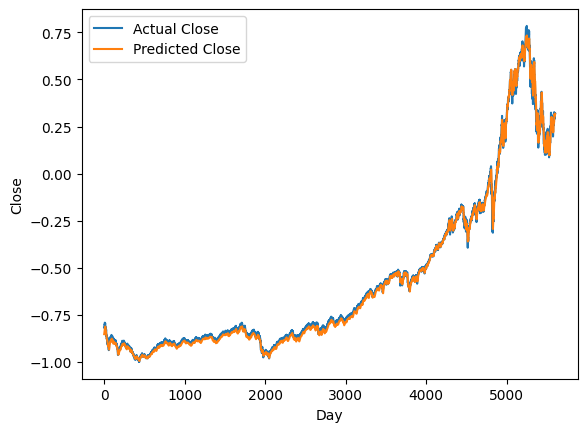

In [27]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


- Before plotting, we inverse transform the scaled predictions (`train_predictions`) and actual closing prices (`new_y_train`) back to their original scale using the `inverse_transform` method of the MinMaxScaler (`scaler`).
- This step is necessary because the LSTM model was trained on scaled data, and we want to visualize the predictions in the original scale.

In [28]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 2349.01865175,  2394.78963653,  2410.79283513, ...,
       12116.27357894, 12124.66050882, 12152.94736774])

In [29]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 2640.57015661,  2626.50009969,  2618.54991108, ...,
       12123.46982732, 12157.71982683, 12153.41006392])

- We plot the actual closing prices (`new_y_train`) and the predicted closing prices (`train_predictions`) on the same graph in their original scale.


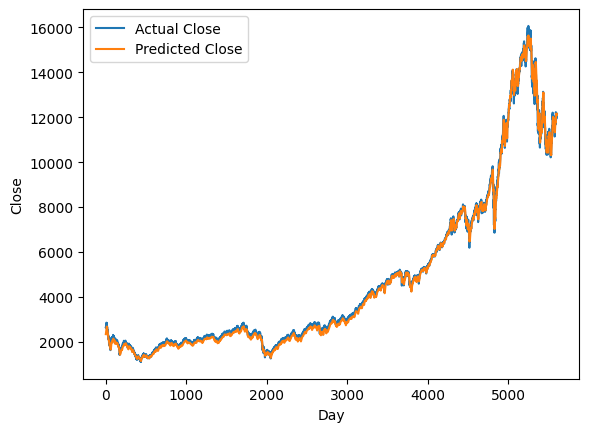

In [30]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


- We pass the test features (`X_test`) to the LSTM model (`model`) and obtain predictions for the closing prices.
- Since the predictions are stored on the device (GPU), we detach them from the computation graph (`detach()`), move them back to the CPU (`cpu()`), and convert them to a NumPy array (`numpy()`).
- Finally, we flatten the predictions to make them compatible with plotting.

In [31]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([12167.40025959, 12180.85438653, 12157.21645131, 12155.00129956,
       12129.34686749, 12026.38523662, 11985.38346657, 12053.95134765,
       12113.74197694, 12153.47594946, 12138.26138083, 12119.51993923,
       12096.11759473, 12177.3509728 , 12213.46423537, 12209.23807723,
       12261.0116341 , 12304.01043483, 12321.55944797, 12369.82010759,
       12381.50381018, 12449.27757085, 12560.16343541, 12614.76757488,
       12682.42104452, 12672.81772779, 12647.02154197, 12710.1868087 ,
       12834.76139266, 12917.21215584, 12950.58967106, 13040.95817921,
       13152.51487837, 13224.54025296, 13288.69879413, 13263.33635479,
       13302.5677005 , 13331.22591429, 13416.5731456 , 13500.76987562,
       13575.98970067, 13682.24261379, 13724.36244151, 13750.52898393,
       13713.49282465, 13734.08305447, 13688.34151852, 13607.57233404,
       13629.05950565, 13644.37539826, 13654.67700189, 13736.12600537,
       13789.53921377, 13824.14409676, 13818.31472378, 13808.27865884,
      

- Similar to the training predictions, we inverse transform the scaled predictions (`test_predictions`) and actual closing prices (`new_y_test`) back to their original scale using the `inverse_transform` method of the MinMaxScaler (`scaler`).


In [32]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([12157.23042703, 12059.55960476, 12072.45994377, 12037.20019843,
       11799.16023115, 11854.34960393, 12142.24021863, 12226.58019978,
       12212.59948765, 12080.50970939, 12025.3300697 , 11966.40044465,
       12235.41011011, 12256.91999226, 12179.54990273, 12306.44046328,
       12328.50987341, 12284.74016193, 12365.20986668, 12343.04986394,
       12500.57021318, 12688.83989343, 12657.90039279, 12720.78015551,
       12560.25003497, 12484.16022129, 12698.08982407, 12975.6903152 ,
       13017.42980366, 12935.29000027, 13100.98040616, 13240.76955875,
       13229.42975871, 13276.41987557, 13104.90034628, 13238.5194677 ,
       13259.13964549, 13461.91986743, 13573.320338  , 13626.48048603,
       13782.82038599, 13689.57038369, 13667.29008992, 13502.2001409 ,
       13630.61031153, 13492.51945858, 13335.78025231, 13555.67000088,
       13591.75007112, 13591.33005079, 13787.92002669, 13816.76940837,
       13791.65054588, 13679.04017719, 13660.71975418, 13685.48048882,
      

- We plot the actual closing prices (`new_y_test`) and the predicted closing prices (`test_predictions`) on the same graph.


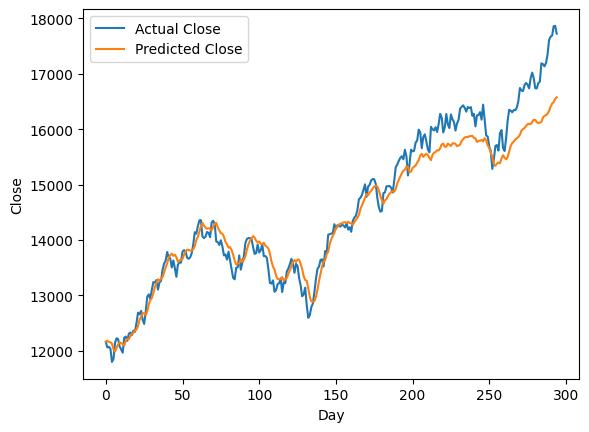

In [33]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [34]:
import plotly.graph_objects as go

results_df = pd.DataFrame({'Actual': new_y_test, 'Predicted': test_predictions})

fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], name='Actual'))

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], name='Predicted'))

fig.update_layout(
    title="Actual vs Predicted Prices of NASDAQ Composite Index",
    xaxis_title="Index",
    yaxis_title="Price",
    legend=dict(x=0, y=1, traceorder="normal"),
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

In [35]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(new_y_test, test_predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 147835.31640572293
Root Mean Squared Error: 384.49358434923585


In [36]:
from sklearn.metrics import r2_score

r2 = r2_score(new_y_test, test_predictions)
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.9288975186700605


As we can see from the Training and Validation errors which are after 30 epochs very less and also from the final graph and r2_score that the LSTM model was able to detect the changes in the stock price on a daily basis with a good accuracy and as seen from the graph the predicted test line was able to follow the actual test line.

### XGBoost MODEL

Importing the necessary libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

Loading the Dataset

In [38]:
data = pd.read_csv('NASDAQ_Composite_Dataset.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,02-01-2001,2474.159912,2474.159912,2273.070068,2291.860107,2291.860107,1918930000
1,03-01-2001,2254.560059,2618.030029,2251.709961,2616.689941,2616.689941,3188000000
2,04-01-2001,2593.959961,2644.800049,2549.830078,2566.830078,2566.830078,2610680000
3,05-01-2001,2573.110107,2574.620117,2395.389893,2407.649902,2407.649902,2104670000
4,08-01-2001,2388.719971,2397.060059,2299.649902,2395.919922,2395.919922,1850590000


Plotting the Close Prices with Date

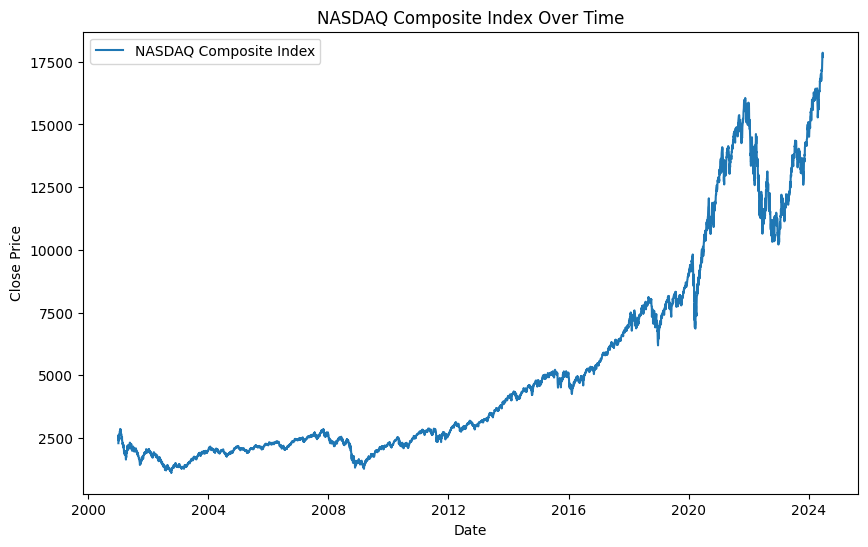

In [39]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values('Date')

plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Close'], label='NASDAQ Composite Index')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('NASDAQ Composite Index Over Time')
plt.legend()
plt.show()

- `num_lag_days = 5`: Specifies the number of lag days to consider for creating lag features.
- `for i in range(1, num_lag_days + 1)`: Iterates over each lag day from 1 to `num_lag_days`.
- `data[f'Close_Lag_{i}'] = data['Close'].shift(i)`: For each lag day, a new feature column is created in the DataFrame (`data`) containing the lagged values of the 'Close' price. The `shift` function is used to shift the 'Close' price values by `i` periods to create lagged features.
- `data = data.dropna()`: After creating lag features, rows with NaN values resulting from the lag operation are removed from the DataFrame.
- `validation_percentage = 0.15` and `test_percentage = 0.05`: Define the percentages of data to allocate for the validation and test sets, respectively.
- `num_samples = len(data)`: Total number of samples in the dataset.
- `validation_index` and `test_index`: Calculate the indices to split the data into train, validation, and test sets based on the defined percentages.
- Data is split into `X_train`, `y_train`, `X_val`, `y_val`, `X_test`, and `y_test` using DataFrame slicing based on the calculated indices.

We hvae dropped Date, Close and Adj Close columns from X as Close will be used as Target variable and Adj Close is similar to CLose and in XGBoost there is no need of Date as a feature.

In [40]:
num_lag_days = 5
for i in range(1, num_lag_days + 1):
    data[f'Close_Lag_{i}'] = data['Close'].shift(i)

data = data.dropna()

X = data.drop(['Date', 'Close', 'Adj Close'], axis=1)
y = data['Close']

# Split the data into train, validation, and test sets
validation_percentage = 0.15
test_percentage = 0.05

num_samples = len(data)
validation_index = int(num_samples * (1 - validation_percentage))
test_index = int(num_samples * (1 - test_percentage))

X_train = X.iloc[:validation_index]
y_train = y.iloc[:validation_index]
X_val = X.iloc[validation_index:test_index]
y_val = y.iloc[validation_index:test_index]
X_test = X.iloc[test_index:]
y_test = y.iloc[test_index:]

- `xgb = XGBRegressor(objective='reg:squarederror', random_state=42)`: Initializes an XGBoost regression model with the objective function set to squared error loss and sets the random seed for reproducibility.
  
- `xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)`: Fits the XGBoost model to the training data (`X_train`, `y_train`) and evaluates its performance on the validation set (`X_val`, `y_val`). The `early_stopping_rounds` parameter is set to 10, which allows early stopping if the validation loss does not improve for 10 consecutive rounds. The `verbose` parameter is set to False to suppress the output during training.

- `y_pred = xgb.predict(X_test)`: Uses the trained XGBoost model to make predictions on the test data (`X_test`) and stores the predicted values in `y_pred`.

- `mse = mean_squared_error(y_test, y_pred)`: Calculates the mean squared error (MSE) between the true target values (`y_test`) and the predicted values (`y_pred`) using the `mean_squared_error` function from scikit-learn.

- `print("Mean Squared Error:", mse)`: Prints the computed MSE, which quantifies the average squared difference between the true and predicted values. Lower values of MSE indicate better model performance.

In [41]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)

y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 3374532.442012773


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



  - `param_grid`: Defines a grid of hyperparameters to search over. The grid contains different combinations of values for the hyperparameters `n_estimators`, `max_depth`, and `learning_rate`. These hyperparameters control the complexity and learning rate of the XGBoost model.
  - `grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')`: Initializes the GridSearchCV object with the XGBoost regressor (`xgb`) as the estimator, the hyperparameter grid (`param_grid`), 5-fold cross-validation (`cv=5`), and negative mean squared error (`scoring='neg_mean_squared_error'`) as the evaluation metric.
  - `grid_search.fit(X_val, y_val)`: Performs the grid search with cross-validation on the validation data (`X_val`, `y_val`). GridSearchCV evaluates the performance of each combination of hyperparameters using cross-validation and selects the combination that results in the lowest mean squared error on the validation set.
  - `best_params = grid_search.best_params_`: Retrieves the best hyperparameters found by GridSearchCV. These hyperparameters are the ones that yield the lowest mean squared error on the validation set.
  - GridSearchCV is used with the validation data to search for the best hyperparameters for the XGBoost model. By performing a grid search with cross-validation on the validation set, we can select hyperparameters that generalize well to unseen data and avoid overfitting. This process helps optimize the performance of the model by selecting the hyperparameters that minimize the prediction error on the validation set.


In [42]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.2]
}
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Perform GridSearchCV with validation data
grid_search.fit(X_val, y_val)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


- `best_xgb = grid_search.best_estimator_`: Retrieves the best XGBoost model found by GridSearchCV, which has the optimal hyperparameters.
- `y_pred_best = best_xgb.predict(X_test)`: Uses the best XGBoost model to make predictions on the test data (`X_test`) and stores the predicted values in `y_pred_best`.

Now we calculate the mean squred error to see the variation of our prediction with the actual values.


In [43]:
# Predict on the test data with the best model
best_xgb = grid_search.best_estimator_
y_pred_best = best_xgb.predict(X_test)

# Calculate the Mean Squared Error with the best model
mse_best = mean_squared_error(y_test, y_pred_best)
print("Mean Squared Error (Best Model):", mse_best)

Mean Squared Error (Best Model): 177834.7233428224


Now we will plot the Actual vs predicted stock prices for the test model.

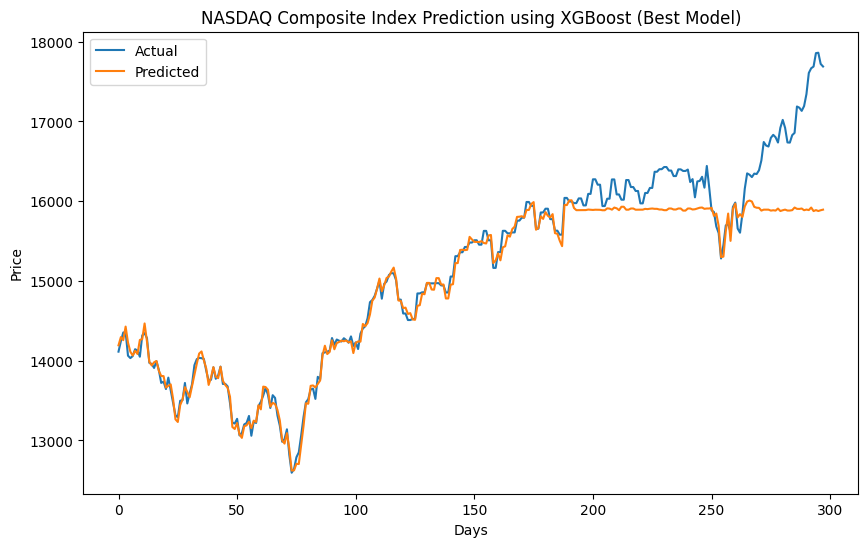

In [44]:
# Plotting the predicted vs. actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred_best, label='Predicted')
plt.title("NASDAQ Composite Index Prediction using XGBoost (Best Model)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

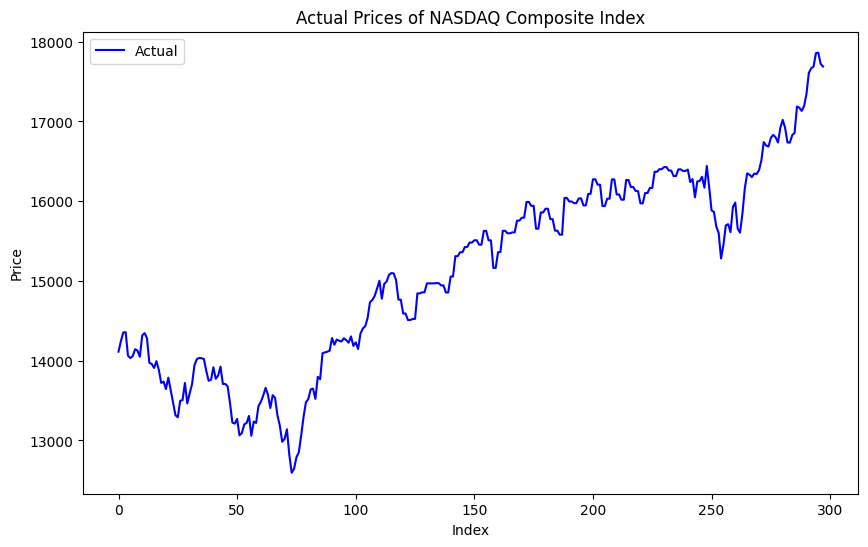

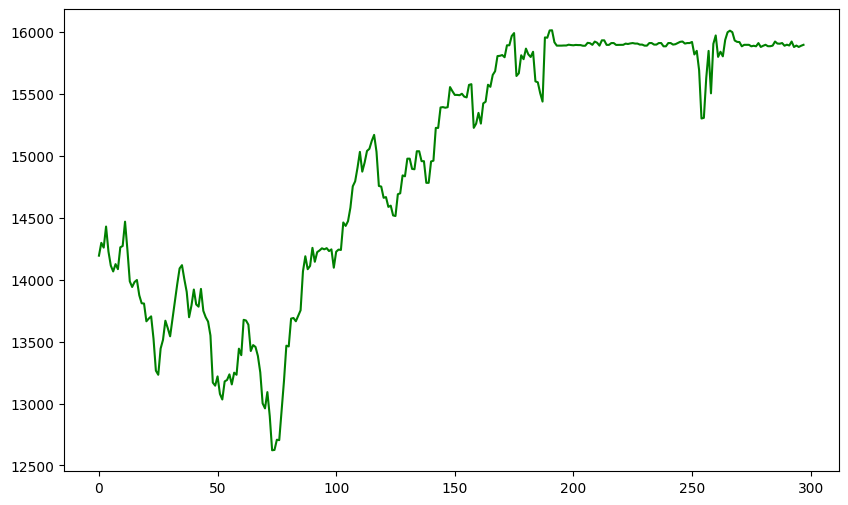

In [45]:
# Plotting the actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='b')
plt.title("Actual Prices of NASDAQ Composite Index")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plotting the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_pred_best, label='Predicted',color='g')
plt.show()

We plot using plotly as it gives interactive visualizations with zoom in zoom out feature for a particular data points also.

In [46]:
import plotly.graph_objects as go

results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_best})

fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], name='Actual'))

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], name='Predicted'))

fig.update_layout(
    title="Actual vs Predicted Prices of NASDAQ Composite Index",
    xaxis_title="Index",
    yaxis_title="Price",
    legend=dict(x=0, y=1, traceorder="normal"),
    autosize=False,
    width=1000,
    height=600,
)

fig.show()


In [47]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test.values, y_pred_best)
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.8799483330149676


### RANDOM FOREST CLASSIFIER MODEL

We start by importing necessary libraries.

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

**Train-Validation-Test Split**: The data is divided into three sets: training, validation, and test sets. The `validation_percentage` and `test_percentage` variables define the proportions of the data allocated for validation and test sets, respectively. The data is split based on these percentages using integer indexing.

**Random Forest Regression**: The code then iterates over a list of candidate values for the number of estimators (`n_estimators`) in the Random Forest model. For each value, a Random Forest regressor is trained on the training data (`X_train`, `y_train`).

**Validation**: After training the model, it predicts the target variable for the validation set (`X_val`). Mean Squared Error (MSE) is calculated between the predicted values (`y_val_pred`) and the actual values (`y_val`).

**Best Model Selection**: The code selects the model with the lowest MSE on the validation set. If the MSE obtained with the current `n_estimators` value is lower than the best MSE found so far, the current `n_estimators` value is updated as the best, along with its corresponding MSE.

Overall, this code segment performs hyperparameter tuning for the Random Forest model by iterating over different values of `n_estimators` and selecting the model with the best performance on the validation set. This process ensures that the selected model generalizes well to unseen data and helps avoid overfitting.

In [49]:
df = pd.read_csv('NASDAQ_Composite_Dataset.csv')

X = df.drop(columns=['Date', 'Close','Adj Close'])
y = df['Close']

# Split the data into train, validation, and test sets
validation_percentage = 0.15
test_percentage = 0.05

num_samples = len(data)
validation_index = int(num_samples * (1 - validation_percentage))
test_index = int(num_samples * (1 - test_percentage))

X_train = X.iloc[:validation_index]
y_train = y.iloc[:validation_index]
X_val = X.iloc[validation_index:test_index]
y_val = y.iloc[validation_index:test_index]
X_test = X.iloc[test_index:]
y_test = y.iloc[test_index:]

best_n_estimators = None
best_mse = float('inf')

for n_estimators in [100, 105, 110, 115, 120]:
    rf_regressor = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf_regressor.fit(X_train, y_train)
    y_val_pred = rf_regressor.predict(X_val)

    mse = mean_squared_error(y_val, y_val_pred)

    if mse < best_mse:
        best_n_estimators = n_estimators
        best_mse = mse

**Final Model Training**: After selecting the best hyperparameter (`best_n_estimators`) based on the validation set, a final Random Forest regressor model is trained using this optimal parameter value.

**Concatenating Train and Validation Sets**: The training and validation sets (`X_train`, `y_train`, `X_val`, `y_val`) are concatenated along the rows using the `pd.concat()` function. This concatenation is performed to utilize the entire labeled data available for training the final model.

**Model Training**: The final Random Forest regressor (`final_rf_regressor`) is instantiated with the optimal number of estimators (`best_n_estimators`) and a random state for reproducibility. The model is then trained on the concatenated training and validation data.

**Testing**: After training the final model, it is evaluated on the test set (`X_test`) to obtain predictions for the target variable (`y_test_pred`). These predictions will be used to assess the model's performance on unseen data.

The final trained Random Forest regressor is capable of predicting the closing prices of the stock index based on the features provided in the test set.


In [50]:
final_rf_regressor = RandomForestRegressor(n_estimators=best_n_estimators, random_state=42)
final_rf_regressor.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_test_pred = final_rf_regressor.predict(X_test)

We then calculate the mean squared error and r2 score for the random forest classifer model.

In [51]:
test_mse = mean_squared_error(y_test, y_test_pred)
print("Best n_estimators:", best_n_estimators)
print("MSE on testing set:",test_mse)

Best n_estimators: 100
MSE on testing set: 152931.84046628687


In [52]:
from sklearn.metrics import r2_score

y_test_pred = final_rf_regressor.predict(X_test)

r2_test = r2_score(y_test, y_test_pred)
print("R-squared score on testing set:",r2_test)

R-squared score on testing set: 0.8969811580710022


We plot the actual vs predicted prices for the test dataset.

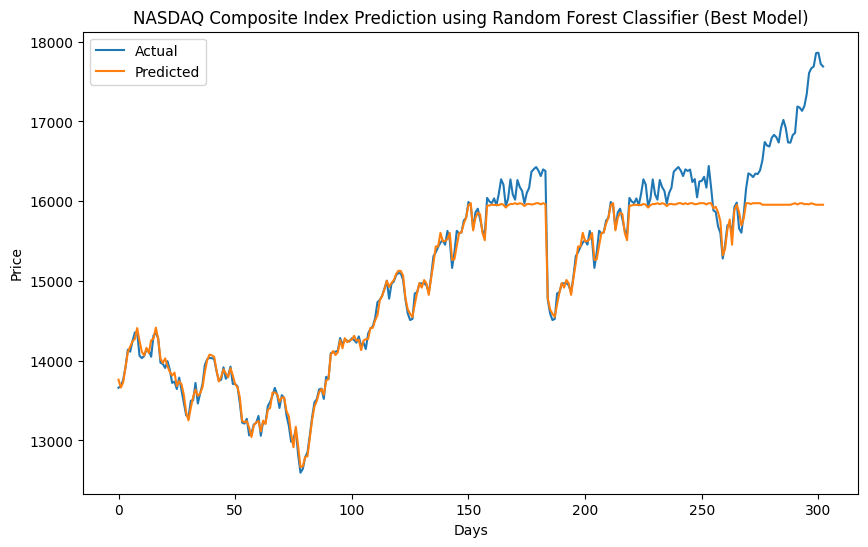

In [53]:
# Plotting the predicted vs. actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(y_test_pred, label='Predicted')
plt.title("NASDAQ Composite Index Prediction using Random Forest Classifier (Best Model)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

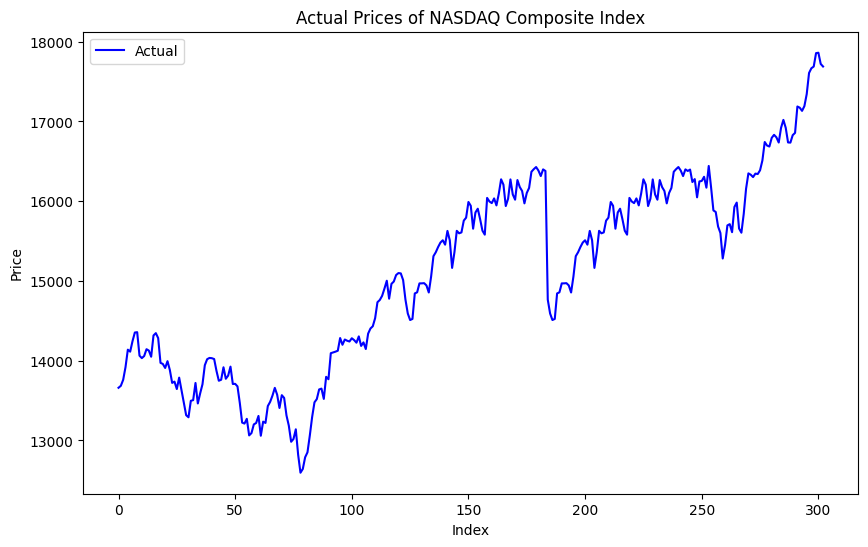

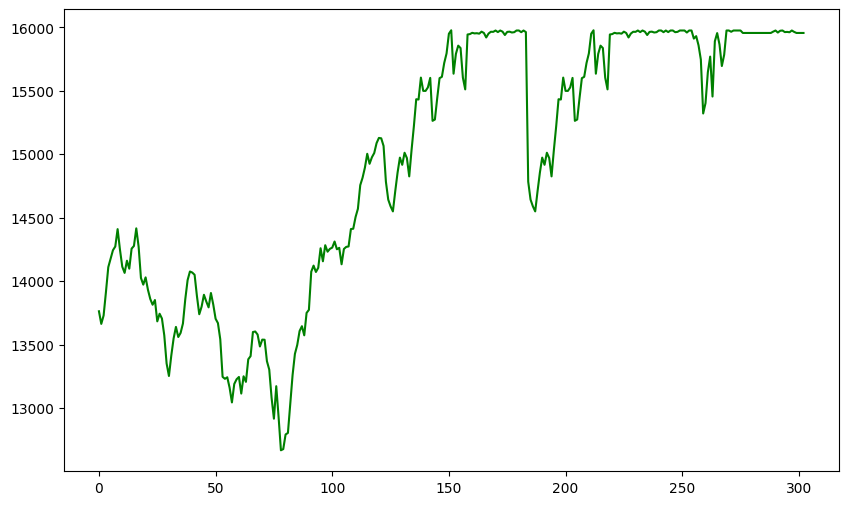

In [54]:
# Plotting the actual prices
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='b')
plt.title("Actual Prices of NASDAQ Composite Index")
plt.xlabel("Index")
plt.ylabel("Price")
plt.legend()
plt.show()

# Plotting the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(y_test_pred, label='Predicted',color='g')
plt.show()

In [55]:
import plotly.graph_objects as go

results_df = pd.DataFrame({'Actual': y_test.values, 'Predicted': y_test_pred})

fig = go.Figure()

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Actual'], name='Actual'))

fig.add_trace(go.Scatter(x=results_df.index, y=results_df['Predicted'], name='Predicted'))

fig.update_layout(
    title="Actual vs Predicted Prices of NASDAQ Composite Index",
    xaxis_title="Index",
    yaxis_title="Price",
    legend=dict(x=0, y=1, traceorder="normal"),
    autosize=False,
    width=1000,
    height=600,
)

fig.show()

We can see that the R^2 is coming highest for this model which tells us that this can be the best model of the lot and also from the graph we can see that it is able to predict te shape of prices pretty accurately.

### RESULTS

- Our analysis identified the LSTM model as the top performer, boasting the lowest MSE and highest R-squared. In time series analysis, LSTM models excel due to their adeptness in capturing temporal dependencies and sequential patterns. LSTM's prowess stems from its specialized memory cells, designed to retain information over time, its ability to comprehend the temporal structure inherent in sequential data, and its dynamic parameter learning, which adjusts to changing patterns.
- The RandomForest Regressor, another model used in our study, demonstrated strong performance with its ability to capture complex relationships in the data through its ensemble learning approach. However, its performance was surpassed by the LSTM model.
- While XGBoost and RandomForest Regressor are powerful algorithms, the LSTM model offers a superior alternative for forecasting tasks in time series data